In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import netCDF4 as nc
from sklearn.linear_model import LinearRegression

2024-05-16 09:34:35.745595: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 09:34:35.968384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 09:34:35.968419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 09:34:36.005773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 09:34:36.087083: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#check if GPU is available
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-16 09:34:39.496751: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 09:34:39.615314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 09:34:39.615363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


netcdf

In [3]:
ds = nc.Dataset('data/3/adaptor.cams_regional_fc.retrieve-1711784804.7831938-5284-8-7a022bcb-9f4b-476b-ada5-450f77a5b403.nc')
ds_1 = nc.Dataset('data/3/temprature_wind/POWER_Point_Daily_20240301_20240328_050d4500N_030d3500E_LST.nc')

In [4]:
ds.variables.keys()

dict_keys(['longitude', 'latitude', 'level', 'time', 'o3_conc'])

In [5]:
ds_1.variables.keys()

dict_keys(['T2M', 'WS10M', 'time', 'lat', 'lon'])

In [6]:
ds["longitude"][:]

masked_array(data=[30.35, 30.45, 30.55, 30.65, 30.75],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [8]:
O3 = ds["o3_conc"][:, 0, 0, 0].data

In [9]:
wind = ds_1["WS10M"][:].data.T[0,0]

In [10]:

temp = ds_1["T2M"][:].data.T[0,0]

In [11]:
print(len(O3))
print(len(wind))
print(len(temp))

28
28
28


In [23]:
params = np.array([wind, temp]).T

In [24]:
model = LinearRegression().fit(params[:27], O3[:27])

In [16]:
model.coef_

array([0.5173282 , 0.47848004], dtype=float32)

In [14]:
model.intercept_

59.62824

In [18]:
model.coef_[0] * wind[-1] + model.coef_[1] * temp[-1] + model.intercept_

67.64603

In [21]:
model.predict([[wind[-1], temp[-1]]])

array([67.64603], dtype=float32)

In [26]:
prediction = np.array(model.predict(params))

In [22]:
O3[27]

79.495834

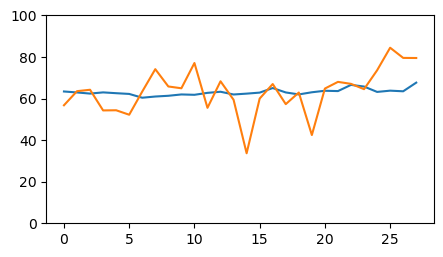

In [33]:
fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(prediction)
ax.plot(O3)
ax.set_ylim([0, 100])
plt.show()

In [47]:
print("max difference = ", np.max(np.abs(prediction - O3)), "=", np.max(np.abs(prediction - O3)) / np.mean(np.abs(prediction - O3)), "% "
      "mean difference = " ,np.mean(np.abs(prediction - O3)), "=" , np.mean(np.abs(prediction - O3)) / np.mean(np.abs(prediction - O3)), "% ")

max difference =  28.688492 = 3.7122946 % mean difference =  7.7279673 = 1.0 % 


Kaggle

In [48]:
df = pd.read_csv('data/kaggle/onehr.data.xls')

In [18]:
df.columns = ["Date","WSR0","WSR1","WSR2","WSR3","WSR4","WSR5","WSR6","WSR7","WSR8","WSR9","WSR10","WSR11","WSR12","WSR13","WSR14","WSR15","WSR16","WSR17","WSR18","WSR19","WSR20","WSR21","WSR22","WSR23","WSR_PK","WSR_AV","T0","T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","T13","T14","T15","T16","T17","T18","T19","T20","T21","T22","T23","T_PK","T_AV","T85","RH85","U85","V85","HT85","T70","RH70","U70","V70","HT70","T50","RH50","U50","V50","HT50","KI","TT","SLP","SLP_","Precp","Target"]

In [19]:
df

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Target
0,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
1,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
2,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
3,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,?,?,?,?,?,?,?,?,0.58,0.0
4,1/6/1998,3.1,3.5,3.3,2.5,1.6,1.7,1.6,1.6,2.3,...,0.09,11.98,11.28,5770,27.95,46.25,10120,?,5.84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,...,0.07,7.93,-4.41,5800,-25.6,21.8,10295,65,0,0.0
2531,12/28/2004,1,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,...,0.04,5.95,-1.14,5845,-19.4,19.1,10310,15,0,0.0
2532,12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,...,0.06,7.8,-0.64,5845,-9.6,35.2,10275,-35,0,0.0
2533,12/30/2004,1.3,0.9,1.5,1.2,1.6,1.8,1.1,1,1.9,...,0.25,7.72,-0.89,5845,-19.6,34.2,10245,-30,0.05,0.0


In [20]:
data = nc.Dataset('data/2/adaptor.cams_regional_fc.retrieve-1706511910.699155-19398-7-0139e086-561b-430a-ad16-805bf0c3497a.nc')

In [21]:
data.variables.keys()

dict_keys(['longitude', 'latitude', 'level', 'time', 'o3_conc'])

In [22]:
data['o3_conc']

<class 'netCDF4._netCDF4.Variable'>
float32 o3_conc(time, level, latitude, longitude)
    _FillValue: -999.0
    species: Ozone
    units: µg/m3
    value: hourly values
    standard_name: mass_concentration_of_ozone_in_air
unlimited dimensions: time
current shape = (1, 10, 3, 3)
filling on

In [23]:
data['latitude']

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    long_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (3,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [24]:
data['level']

<class 'netCDF4._netCDF4.Variable'>
float32 level(level)
    long_name: level
    units: m
unlimited dimensions: 
current shape = (10,)
filling on, default _FillValue of 9.969209968386869e+36 used